In [52]:
# !pip install mne

In [53]:

import pandas as pd

import mne



In [54]:
# https://openbci.com/forum/index.php?p=/discussion/3625/recorded-data-format-and-processing
headers = [
    "Sample Index",
    "EXG Channel 0",
    "EXG Channel 1",
    "EXG Channel 2",
    "EXG Channel 3",
    "EXG Channel 4",
    "EXG Channel 5",
    "EXG Channel 6",
    "EXG Channel 7",
    "Accel Channel 0",
    "Accel Channel 1",
    "Accel Channel 2",
    "Not Used 1",
    "Digital Channel 0",
    "Digital Channel 1",
    "Digital Channel 2",
    "Digital Channel 3",
    "Not Used 2",
    "Digital Channel 4",
    "Analog Channel 0",
    "Analog Channel 1",
    "Analog Channel 2",
    "Timestamp",
    "Marker Channel",
    "Timestamp (Formatted)"
]

In [55]:

"""
KEY: Rerun with new participant number to save new data
"""


# Im being careless here and using backslash. Windows beware.
data_dir = "Processed"
p_num = 5

In [56]:

# First few lines are not data, need to skip them
with open(f'./Participant{p_num}/Participant{p_num}.txt', 'r') as f:
  while f.readline()[0] == "%":
    pass
  Cyton_DF = pd.read_csv(f, sep=",", names=headers)

# X samples, Y columns
print(Cyton_DF.shape)

(525842, 25)


In [57]:
recording_cols = [col for col in headers if col[:3] == "EXG"] # These are the recording channel names
print(recording_cols)

New_Cyton_DF = Cyton_DF[recording_cols].copy()
print(New_Cyton_DF.head())

ch_names = ['CH 1', 'CH 2', 'CH 3', 'CH 4', 'CH 5', 'CH 6', 'CH 7', 'CH 8']
New_Cyton_DF.columns = ch_names
ch_types = ['eeg'] * len(ch_names)
sfreq = 250
info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types=ch_types)


print(New_Cyton_DF.shape)
data = New_Cyton_DF.to_numpy().T
print(data.shape)

raw = mne.io.RawArray(data, info)

['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7']
   EXG Channel 0  EXG Channel 1  EXG Channel 2  EXG Channel 3  EXG Channel 4  \
0    9895.385491   16038.114254   20131.612734  -12129.844681   -2507.329286   
1    9904.013265   16042.383437   20134.294943  -12131.230489   -2504.267097   
2    9915.010323   16046.853786   20135.032551  -12138.159530   -2500.422597   
3    9929.896585   16046.630269   20143.347400  -12145.423847   -2492.934763   
4    9927.035561   16046.831435   20136.932449  -12140.640574   -2501.182556   

   EXG Channel 5  EXG Channel 6  EXG Channel 7  
0   16972.975966    5553.916759   -3153.473515  
1   16982.207237    5553.290910   -3144.935148  
2   16985.403536    5550.586349   -3150.634843  
3   16992.600798    5541.310375   -3128.081933  
4   16996.490001    5541.086857   -3135.212140  
(525842, 8)
(8, 525842)
Creating RawArray with float64 data, n_channels=8, n_times=52584

In [58]:

"""
SRB: White | Forehead
1: Grey | Fp2
2: Purple | F4
3: Blue | F3 
4: Green | T3
5: Yellow | Cz
6: Orange | T4
7: Red | O2
8: Brown | O1
Bias: Black | Mastoid
"""



# To get this to work we would have to rename, ala
raw.rename_channels({
    "CH 1": "Fp2", "CH 2": "F4", "CH 3": "F3", "CH 4": "T3",
    "CH 5": "Cz", "CH 6": "T4", "CH 7": "O2", "CH 8": "O1"
})


montage = "standard_1020"
raw.set_montage(montage)

<RawArray | 8 x 525842 (2103.4 s), ~32.1 MiB, data loaded>

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/home/diego/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


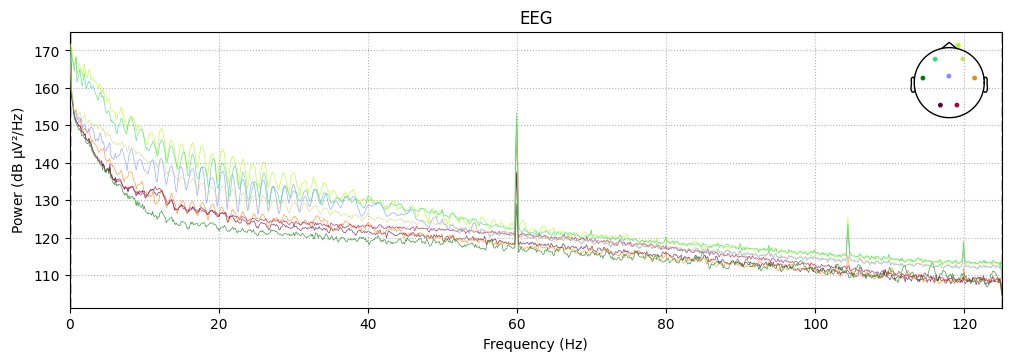

In [59]:
# For P1: Note the odd orange, light green, and blue electrodes: T4, F4, Cz
# We will remedy this later
raw.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband ed

/home/diego/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


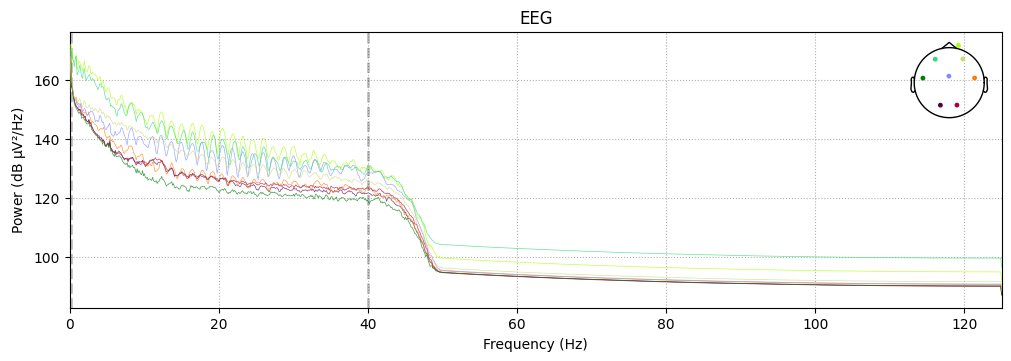

In [60]:
# Filter settings
low_cut = 0.1
hi_cut  = 40

# raw_filt = raw.copy().filter(l_freq=low_cut, h_freq=hi_cut)

raw_filt = raw.copy().notch_filter(60)
raw_filt.filter(l_freq=low_cut, h_freq=hi_cut)
raw_filt.compute_psd().plot()

In [62]:
raw.save(f"{data_dir}/P{p_num}/P{p_num}-raw.fif", overwrite=True)

Overwriting existing file.
Writing /mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-raw.fif
Closing /mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-raw.fif
[done]


[PosixPath('/mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-raw.fif')]

In [61]:
raw_filt.save(f"{data_dir}/P{p_num}/P{p_num}-filt-raw.fif", overwrite=True)

Overwriting existing file.
Writing /mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-filt-raw.fif
Closing /mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-filt-raw.fif
[done]


[PosixPath('/mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-filt-raw.fif')]